<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.1.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [3]:
data = pd.read_csv('ner_dataset.csv', engine='python')
data = data.fillna(method = 'ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [4]:
print("Unique words in crops" , data['Word'].nunique())
print("Unique tags in crops" , data['Tag'].nunique())

Unique words in crops 35172
Unique tags in crops 17


In [5]:
words = list (set(data['Word'].values ) )
words.append("ENDPAD")
num_words = len(words)
tags = list (set(data['Tag'].values ) )
num_tags = len(tags)

In [6]:
num_words , num_tags


(35173, 17)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [7]:
class SentenceGetter (object):
    def __init__(self , data):
        self.n_sent =1 
        self.data =data
        agg_func = lambda s : [ (w,p,t)for w,p,t in zip(s["Word"].values.tolist(),
                                                       s["POS"].values.tolist(),
                                                       s["Tag"].values.tolist() )]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [8]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [9]:
sentences[3]

[('They', 'PRP', 'O'),
 ('left', 'VBD', 'O'),
 ('after', 'IN', 'O'),
 ('a', 'DT', 'O'),
 ('tense', 'NN', 'O'),
 ('hour-long', 'JJ', 'O'),
 ('standoff', 'NN', 'O'),
 ('with', 'IN', 'O'),
 ('riot', 'NN', 'O'),
 ('police', 'NNS', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [10]:
word2idx = { w : i+1 for i ,w in enumerate (words)}
tag2idx = { t : i for i ,t in enumerate (tags)}


In [11]:
word2idx

{'Ireland': 1,
 '44-yard': 2,
 'eight-thousand': 3,
 'Kerguelen': 4,
 'Publication': 5,
 'chief-of-staff': 6,
 'Biak': 7,
 'Afellay': 8,
 'Chookiat': 9,
 'homing': 10,
 'rubber-stamp': 11,
 'Kocharian': 12,
 'Noting': 13,
 'reputation': 14,
 'Six-thousand': 15,
 'undetected': 16,
 'siphoned': 17,
 'Pontchartrain': 18,
 'scapegoating': 19,
 'Roosevelt': 20,
 'cloak': 21,
 'most': 22,
 'clarified': 23,
 'Paralympic': 24,
 'two-decade': 25,
 'embrace': 26,
 'twice-weekly': 27,
 'Celia': 28,
 'Almaty': 29,
 'Recovery': 30,
 'Junichiro': 31,
 'Genetic': 32,
 'fails': 33,
 'Goose': 34,
 'Russian': 35,
 'plaintiffs': 36,
 'basins': 37,
 'drought-stricken': 38,
 'Issoufou': 39,
 'Al-Mansoorain': 40,
 'annotations': 41,
 'firecracker': 42,
 'trained': 43,
 'inaugurated': 44,
 'Fat': 45,
 'lab': 46,
 'grower': 47,
 'Rouen': 48,
 'administered': 49,
 'intensive': 50,
 'guests': 51,
 'carried': 52,
 'Fatou': 53,
 'revelers': 54,
 'go-betweens': 55,
 '22-month': 56,
 'Defectors': 57,
 'Queen': 58,


### Task 5: Padding Input Sentences and Creating Train/Test Splits

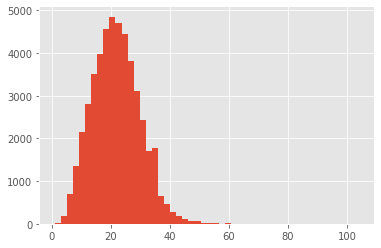

In [12]:
plt.hist ( [len(s) for s in sentences ] , bins=50)
plt.show()

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical 

max_len = 50

X= [[word2idx[w[0]] for w in s] for s in sentences ]
X= pad_sequences(maxlen = max_len , sequences = X, padding ='post' , value = num_words -1)


y= [[tag2idx[w[2]] for w in s] for s in sentences ]
y= pad_sequences(maxlen = max_len , sequences = y, padding ='post' , value = tag2idx["O"])
y= [to_categorical (i , num_classes = num_tags) for i in y]


In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train,y_test =train_test_split(X,y, test_size = 0.1 ,random_state =1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [15]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [16]:
input_word = Input (shape =(max_len,) )
model = Embedding(input_dim = num_words , output_dim = max_len ,input_length =max_len)( input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional( LSTM (units =100 , return_sequences=True , recurrent_dropout=0.1))(model)
out = TimeDistributed( Dense(
    num_tags,
    activation='softmax'))(model)
model = Model (input_word , out)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758650   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,882,867
Trainable params: 1,882,867
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' ,metrics= ['accuracy'])

### Task 7: Train the Model

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

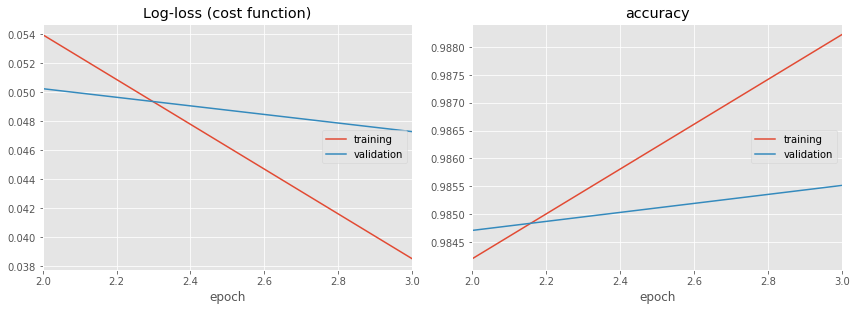

Log-loss (cost function):
training   (min:    0.039, max:    0.192, cur:    0.039)
validation (min:    0.047, max:    0.070, cur:    0.047)

accuracy:
training   (min:    0.956, max:    0.988, cur:    0.988)
validation (min:    0.980, max:    0.986, cur:    0.986)
34530/34530 [==============================] - 177s 5ms/sample - loss: 0.0385 - accuracy: 0.9882 - val_loss: 0.0473 - val_accuracy: 0.9855


In [19]:
early_stopping =EarlyStopping ( monitor='val_accuracy',  patience=1, verbose=0, mode='max',
     restore_best_weights=False
)
callbacks = [PlotLossesCallback(), early_stopping]
history = model.fit(x_train , np.array(y_train ) , 
                    validation_split =0.2,
                    batch_size = 32 ,
                    epochs= 3,
                    verbose = 1,
                   callbacks = callbacks)

### Task 8: Evaluate Named Entity Recognition Model

In [20]:
model.evaluate (x_test , np.array(y_test))

4796/4796 [==============================] - 5s 1ms/sample - loss: 0.0488 - accuracy: 0.9851


[0.04877542711800591, 0.9851293]

In [24]:
i = np.random.randint (0,x_test.shape[0])
p= model.predict(np.array([x_test[i]]))
p= np.argmax(p, axis =-1)

y_true = np.argmax (np.array(y_test),axis=-1)[i]
print( "{:15}{:5}\t {}\n".format("Word" , "True", "pred"))
print("-"*30)
for w,true, pred in zip (x_test[i] , y_true, p[0] ):
    print( "{:15}{}\t {}".format(words[w-1] , tags [true] , tags[pred]))

Word           True 	 pred

------------------------------
The            B-org	 O
Associated     I-org	 I-org
Press          I-org	 I-org
says           O	 O
the            O	 O
recommendation O	 O
by             O	 O
Colonel        O	 O
James          B-per	 B-per
Daniel         I-per	 I-per
will           O	 O
be             O	 O
forwarded      O	 O
to             O	 O
Army           B-org	 B-org
officials      O	 O
for            O	 O
a              O	 O
final          O	 O
decision       O	 O
.              O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	 O
Balfour        O	